# Import Files

In [9]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [8]:
with open('models/residual_model.pkl', 'rb') as f:
    r_model = pickle.load(f)

with open('models/trend_model.pkl', 'rb') as f:
    t_model = pickle.load(f)

# Analyze Model Results

The best model to describe temperature data is a mean-reverting process, or more specifically the Ornstein-Uhlenbeck process.
$$dT_t = \kappa(\mu - T_t)dt + \sigma{dW_t}$$

However, we note that in the PACF chart, there is a high partial autocorrelation at lag 1. This indicates that $E[T_t]$ is not simply $\bar{T}$.

If we follow the same steps to solve the Vasicek Mean-Reverting Process by letting $X_t = e^{\kappa{t}}T_t$

$$dX_t = f_{t}dt + f_{T}dT + \frac{1}{2}f_{TT}(dT)^2$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}dT + 0$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}(\kappa(\mu - T_t)dt + \sigma{dW_t})$$
$$dX_t = \kappa\mu{e^{\kappa{t}}}dt + \sigma{e^{\kappa{t}}}{dW_t}$$

Now, instead of setting the origin to be 0, we will use $s$ to model a reversion to a changing mean temperature by assuming that temperature follows a Markov chain:
$$X_t - X_s = \kappa{\int_{s}^{t}e^{\kappa{u}}}\mu{du} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

We also need to change $du$ to $d\bar{T}$ by letting $\bar{T} = \kappa{\mu}$:
$$X_t - X_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

Afterwards, we can further simplify to:
$$e^{\kappa{t}}T_t - e^{\kappa{s}}T_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$e^{\kappa{t}}T_t = e^{\kappa{s}}T_s + {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$T_t = e^{\kappa(s-t)}T_s + {\int_{s}^{t}e^{\kappa(u-t)}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa(u-t)}}{dW_u}$$
$$T_t = e^{-\kappa(t-s)}T_s + \bar{T_t} - \bar{T_s}e^{-\kappa(t-s)}+ \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} + \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$

Therefore,
$$E[T_t] = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)}

In [ ]:
class TemperatureModel:
    def __init__(self, trend_model, residual_model, forecast_t:int, training_periods:int=60753, latest_temp:float=19.4078):
        self.forecast_t = forecast_t
        self.latest_temp = latest_temp
        self.training_periods = training_periods
        self.trend_model = trend_model
        self.residual_model = residual_model
        
    def get_seasonal_data(self, forecast_t:int, training_periods:int=60753) -> np.array:
        t = forecast_t + training_periods
        time = np.arange(training_periods+1, t+1)
        omega = 2*np.pi/365
        ot = omega*time
        
        a = 3.4997*np.cos(ot)
        b = 2.7523*np.sin(ot)
        c = -0.3661*np.cos(2*ot)
        d = -0.1726*np.sin(2*ot)
        result = a+b+c+d
        return result
    
    def get_trend_data(self, forecast_t:int=0, latest_temp:float=19.4078, fitted_val:bool=False) -> np.array:
        standardized_forecasts = self.trend_model.fittedvalues if fitted_val else self.trend_model.forecast(forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        forecasts = standardized_forecasts*TREND_STD + TREND_MEAN
        result = latest_temp + np.cumsum(forecasts)
        return result.values
    
    def get_residual_data(self, forecast_t:int=0, fitted_val:bool=False) -> np.array:
        result = self.residual_model.fittedvalues if fitted_val else self.residual_model.forecast(forecast_t)
        return result.values
    
    def get_fitted_temps(self) -> np.array:
        self.past_trend = self.get_trend_data(fitted_val=True) 
        self.past_seasonal = self.get_seasonal_data(self.training_periods, 0)
        self.past_residual = self.get_residual_data(fitted_val=True)
        self.fitted_temp = self.past_seasonal[15:] + self.past_trend[14:] + self.past_residual #Indexed due to residual model AR(15) lag
    
    def pipeline(self) -> np.array:
        self.seasonal = self.get_seasonal_data(self.forecast_t, self.training_periods)
        self.trend = self.get_trend_data(self.forecast_t, self.latest_temp)
        self.residual = self.get_residual_data(self.forecast_t)
        self.forecast = self.seasonal + self.trend + self.residual

In [ ]:
forecast = TemperatureModel(t_model, r_model, 30)
forecast.get_fitted_temps()

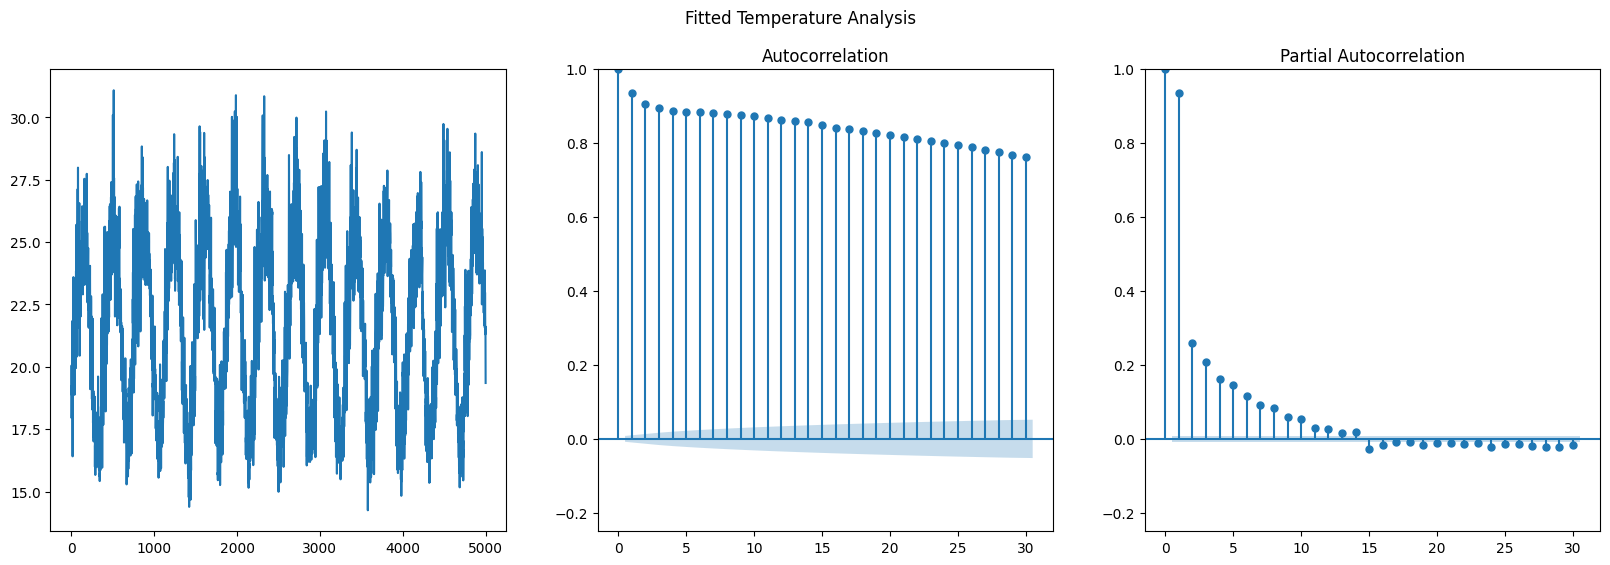

In [43]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('Fitted Temperature Analysis')

axes[0].plot(forecast.fitted_temp[-5000:])

plot_acf(forecast.fitted_temp, lags=30, ax=axes[1])
axes[1].set_ylim([-0.25, 1])

plot_pacf(forecast.fitted_temp, lags=30, ax=axes[2])
axes[2].set_ylim([-0.25, 1])

plt.show()